In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

class SpendAnomaliesModel:
    
    raw_data = pd.DataFrame()
    spend_data = pd.DataFrame()
    model_data = pd.DataFrame()
    date_columns = []
    
    def __init__(self, data_file_path):
        
        self.date_columns = ['[PO]PO Create Date (Date)', '[PO]PO Dispatch Date (Date)', '[INV]Voucher Create Date (Date)', \
                        '[INV]Voucher Invoice Date (Date)', '[INV]Payment Date (Date)', '[INV]Voucher Received Date B (Date)',\
                        '[INV]Accounting Date (Date)']
        
        self.raw_data = pd.read_csv(data_file_path,
                              na_values = ['Unclassified', '-', 'nan'],                        
                              thousands = ',',
                              parse_dates = self.date_columns,
                              #nrows = 100,
                              infer_datetime_format = True)
        
        print(self.raw_data.info())
        all_columns = self.raw_data.columns
        
        self.spend_data = self.raw_data[self.raw_data['[INV]Commodity (enriched) (Custom Category (L2))'] == '1050 Packaging']
        
        print(self.spend_data.shape)
        self.parse_data()
        
    def parse_data(self):
        
        for date in self.date_columns:
            self.spend_data[date] = pd.to_datetime(self.spend_data[date], 
                      errors = 'coerce', 
                      infer_datetime_format = True)
            
        print("#1) Dealing with Missing Values ....")
        
        '''
        # Requester name with unknown # check with id first
        self.spend_data['PO_Requester_Name'] = np.where(self.spend_data[
                'PO_Requester_Name'].isnull(), 'unknown', self.spend_data[
                        'PO_Requester_Name'])
        
        # PO_Terms missing Values
        self.spend_data['PO_Terms'] = np.where(self.spend_data['PO_Terms'].isnull(), 
                                     self.spend_data['INV_Voucher_Terms'],
                                     self.spend_data['PO_Terms'])

        self.spend_data['INV_Voucher_Terms'] = np.where(self.spend_data['INV_Voucher_Terms'].isnull(), 
                                             self.spend_data['PO_Terms'],
                                             self.spend_data['INV_Voucher_Terms'])
                                             
        '''
        
        self.spend_data['[PO]PO Terms (PO Terms)'].fillna('0', inplace = True)
        
        self.spend_data['[INV] Voucher Terms'].fillna('0', inplace = True)

        
        # UOM_Missing values 
        # UOM of PO and Voucher are mostly same
        # IF PO UOM are missing fillinf it with voc uOM
        '''
        self.spend_data['PO_UOM'] = np.where(self.spend_data['PO_UOM'].isnull(),
                  self.spend_data['INV_UOM'], self.spend_data['PO_UOM'])
        
        
        # IF Voc UOM are missing filling it with 
        self.spend_data['INV_UOM'] = np.where(self.spend_data['INV_UOM'].isnull(),
                  self.spend_data['PO_UOM'], self.spend_data['INV_UOM'])
                  
        '''
        
        # UOM _Missing Values
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] = np.where(self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].isnull(),
                 'unknown', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        
        self.spend_data['[PO]UOM (Unit of Measure)'] = np.where(self.spend_data['[PO]UOM (Unit of Measure)'].isnull(),
                  'unknown', self.spend_data['[PO]UOM (Unit of Measure)'])
        
       
        # PO_Internal_Part_Number should be mandatory
        # Filling it with -1 to make it distinctable
        self.spend_data['[INV]Part (Internal Part Number)'] = np.where(
                self.spend_data['[INV]Part (Internal Part Number)'].isnull(),
                -1,
                self.spend_data['[INV]Part (Internal Part Number)'])
        
        # Removing the preceding zeroes from the item id
        self.spend_data['[INV]Part (Internal Part Number)'] = self.spend_data[
        '[INV]Part (Internal Part Number)'].apply(lambda x : str(x).lstrip('0'))
        
        #Removing remaining null values from imp cols
        self.spend_data.dropna(subset = self.date_columns, inplace = True)
              
        self.spend_data['[PO]Part (Part Name)'] = self.spend_data['[PO]Part (Part Name)'
                  ].apply(lambda x : str(x).lstrip('0'))
        
        print('#2) Extracting number from PO terms')
        
        self.spend_data['PO_Disc_Days'] = self.spend_data['[PO]PO Terms (PO Terms)'].apply(
                lambda x : re.findall(r"(?<=/)[0-9][0-9]", str(x), re.I))
        
        self.spend_data['PO_Disc_Days'] = self.spend_data['PO_Disc_Days'].apply(
                lambda x : x[0]  if x  else 0)
        
        
        self.spend_data['PO_Days_To_Pay'] = self.spend_data['[PO]PO Terms (PO Terms)'].apply(
                lambda x : re.findall(r' [0-9][0-9]|(?<=NET)[0-9][0-9]', str(x),
                                      re.I))
        
        self.spend_data['PO_Days_To_Pay'] = self.spend_data['PO_Days_To_Pay'].apply(
                lambda x : x[0]  if x  else 0)
        
        print("#3 Extracting invoice terms")
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['[INV] Voucher Terms'].apply(
                lambda x : re.findall(r"(?<=/)[0-9][0-9]|\d+ days \d+", str(x)))
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['Inv_Disc_Days'].apply(
                lambda x : "".join(x))
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['Inv_Disc_Days'].apply(
                lambda x : re.findall(r'\d+', x))
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['Inv_Disc_Days'].apply(
                lambda x : x[0]  if x  else 0)
    
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['[INV] Voucher Terms'].apply(
                lambda x : re.findall(r"\d+$|\d+ days?", str(x), re.I))
        
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['Inv_Days_To_Pay'].apply(
                lambda x : x[0]  if len(x)==1 else (x[1] if len(x)==2 else 0))
        
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['Inv_Days_To_Pay'].apply(
                lambda x : re.findall(r'\d+', str(x)))
        
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['Inv_Days_To_Pay'].apply(
                lambda x : ''.join(x))
    
        self.spend_data[['PO_Disc_Days', 'PO_Days_To_Pay', 'Inv_Disc_Days', 
                    'Inv_Days_To_Pay']] = self.spend_data[['PO_Disc_Days', 
                                      'PO_Days_To_Pay', 'Inv_Disc_Days', 
                                      'Inv_Days_To_Pay']].astype('int', inplace = True)
        
        print("#4 Correcting Voucher Quantity when there are returns")
        
        self.spend_data['sum(Voucher Quantity)'] =  np.where(self.spend_data['sum(Voucher amount USD)'] < 0, \
                                         -np.absolute(self.spend_data['sum(Voucher Quantity)']), self.spend_data['sum(Voucher Quantity)'])
        
        
        print("#5. Actual  Voucher_Unit_Price Calculation")
        self.spend_data['sum(Voucher Unit Price)'] = self.spend_data['sum(Voucher Unit Price)'] / self.spend_data['count(InvoiceLineItem)']
        
        print("#6. Different Units of Measure - adjusting PO, VO quantities")
        
        #If the UOMs are different and the voucher quantity is 0, then make both UOMs the same -  
        # the quantity difference is going to be retained.
        self.spend_data['[PO]UOM (Unit of Measure)'] = np.where(self.spend_data['sum(Voucher Quantity)'] == 0, \
                                       self.spend_data['[INV]Unit Of Measure (Unit of Measure)'], self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #If the UOMs are different and the voucher quantity is equal to PO quantity, make the UOMs the same.
        self.spend_data['[PO]UOM (Unit of Measure)'] = np.where(self.spend_data['sum(Voucher Quantity)'] == self.spend_data['sum(PO line quantity)'], \
                                       self.spend_data['[INV]Unit Of Measure (Unit of Measure)'], self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #Doing valid conversions - pound to kilogram - 1 kilogram = 2.20462 pounds
        # meter to foot - 1 meter = 3.28084 feet
        # km to meter - 1 km = 1000 meters
        # kg to gram - 1 kg = 1000 grams
        
        #pound to kilogram - doing the conversion
        
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'pound') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 2.20462,  self.spend_data['sum(Voucher Quantity)'] )
        
        #Making units the same after conversion                        
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'pound') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                     'kilogram', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='pound'), \
                                                   self.spend_data['sum(PO line quantity)'] / 2.20462,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='pound'), \
                                                     'kilogram', self.spend_data['[PO]UOM (Unit of Measure)'])
            
        #foot to meter
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'foot') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 3.28084,  self.spend_data['sum(Voucher Quantity)'] )
        
                                
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'foot') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                     'meter', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='foot'), \
                                                   self.spend_data['sum(PO line quantity)'] / 3.28084,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='foot'), \
                                                     'meter', self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #meter to km
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='km'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 1000,  self.spend_data['sum(Voucher Quantity)'] )
        
                                
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='km'), \
                                                     'km', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'km') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                   self.spend_data['sum(PO line quantity)'] / 1000,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'km') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                     'km', self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #gram to kilogram
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'gram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 1000,  self.spend_data['sum(Voucher Quantity)'] )
        
                                
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'gram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                     'kilogram', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='gram'), \
                                                   self.spend_data['sum(PO line quantity)'] / 1000,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='gram'), \
                                                     'kilogram', self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #Remove other rows which have different UOMs
        self.spend_data['diffUOM'] = (self.spend_data['[PO]UOM (Unit of Measure)'] == self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend = self.spend_data[self.spend_data['diffUOM'] == False]
        
        self.create_features()
        
        
        
    def create_features(self):
        
        # Taking the unique of PO amount As PO Amount got duplicated
        # due to diff number of vouchers raised against same PO
        self.spend_data['total_PO_Amount'] = self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Id'])['sum(PO Amount)'].transform('unique')
            

        self.spend_data['total_PO_Amount'] = self.spend_data['total_PO_Amount'].apply(
                lambda x : sum(x) if isinstance(x, np.ndarray) else x)
               
        # Doing the same with quantity
        self.spend_data['total_PO_quantity'] = self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Line'])['sum(PO line quantity)'].transform('unique')
        
        self.spend_data['total_PO_quantity'] = self.spend_data['total_PO_quantity'
                ].apply(lambda x : sum(x) if isinstance(x, np.ndarray) else x)
               
        ## Calculating total voucher amount and quantity received 
        self.spend_data['total_voucher_amount']= self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Line'])['sum(Voucher Amount)'].transform('sum')
        
        self.spend_data['total_voucher_quantity']= self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Line'])['sum(Voucher Quantity)'].transform('sum')
      
        
        #self.spend_data = self.spend_data
        
        # Some times we receive voucher quantity less that PO quantity; so
        # we need to calculate PO amount based on the voucher quantity received
        self.spend_data['po_amount_voucher_quantity'] = ((self.spend_data['total_PO_Amount'
           ] / self.spend_data['total_PO_quantity']) * self.spend_data['total_voucher_quantity'])
        
        '''
        #Calulating PO based on logic
        # Why do we need this feature?
        #1.if VOC qty is more than PO - take original PO amt
        #2.if voc qty is less than PO - cal PO amt based on voc qty received
        self.spend_data['po_amt_based_on_voc_qty'] = np.where(self.spend_data[
                'total_voucher_quantity'] <= self.spend_data[
                        'total_PO_quantity'], self.spend_data[
                                'po_amount_of_voucher_quantity'
                                ], self.spend_data['total_PO_Amount'])
                                
        '''
        
        
        self.spend_data['qty(PO-Voc)'] = np.round(self.spend_data['total_PO_quantity'] - \
                                                  self.spend_data['total_voucher_quantity'], 2)
        
        '''
        #Not using this feature
        self.spend_data['rel_diff_in_qty'] = np.round((self.spend_data['qty(PO-Voc)']/
                  self.spend_data['total_PO_quantity']) * 100)
        '''
        
        #self.spend_data['amt_diff(PO-Voc)'] = np.round(self.spend_data['po_amt_based_on_voc_qty'] - self.spend_data['total_voucher_amount'], 2)
        
    
        self.spend_data['amt_diff(PO-Voc)'] = np.round(self.spend_data['total_PO_Amount'] - \
                                                       self.spend_data['total_voucher_amount'], 2)
        
        # Date Related Features
        
        # PO Create Date should be more than PO Dispatch
        self.spend_data['po_dispatch-po_create'] = (self.spend_data['[PO]PO Dispatch Date (Date)'] - \
                                                    self.spend_data['[PO]PO Create Date (Date)']).dt.days.astype('int')
        
        # Voc create date should be later than voc rev
        self.spend_data['voc_create_date-voc_rec_date'] = (self.spend_data['[INV]Voucher Create Date (Date)'] - \
                                                self.spend_data['[INV]Voucher Received Date B (Date)']).dt.days.astype('int')
              
        # voc inv date should come before voc rev date
        self.spend_data.dropna(subset = ['[INV]Voucher Invoice Date (Date)'], inplace = True)
        
        self.spend_data['voc_rev_date-voc_inv_date'] = (self.spend_data['[INV]Voucher Received Date B (Date)'] - \
                                            self.spend_data['[INV]Voucher Invoice Date (Date)']).dt.days.astype('int')
        
        
        # PO create date should come before PO recv date
        self.spend_data['voc_rev_date-po_create_date'] = (self.spend_data['[INV]Voucher Received Date B (Date)'] - \
                                  self.spend_data['[PO]PO Create Date (Date)']).dt.days.astype('int')
        
        # Accounting date should come late than PO date
        self.spend_data['accounting_date-po_create_date'] = (self.spend_data['[INV]Accounting Date (Date)'] - \
                                    self.spend_data['[PO]PO Create Date (Date)']).dt.days.astype('int')
        
        # Payment_Date - Voc Rec Date for Early payment
        self.spend_data['payment_after_days'] = (self.spend_data['[INV]Accounting Date (Date)'] - \
                                    self.spend_data['[INV]Voucher Received Date B (Date)']).dt.days.astype('int')
        
        ### Unit price variation 
        ### Actual unit price is unit price/count of line item
        ### Few unit price is in negative making it positive
        ### For some PO unit price is 0
        self.spend_data.dropna(subset = ['[PO]Part (Internal Part Number)'], axis = 0,
                          inplace = True)
        
        self.spend_data['Voucher_Unit_Price_Range'] = self.spend_data.groupby(
                ['[INV] PO Id', '[INV] PO Line', '[PO]Part (Internal Part Number)'])[
        'sum(Voucher Unit Price)'].transform(np.ptp)
        
        
        model_features = ['qty(PO-Voc)', 'amt_diff(PO-Voc)', 'Voucher_Unit_Price_Range', 'payment_after_days', \
                        'po_dispatch-po_create', 'voc_create_date-voc_rec_date', 'voc_rev_date-voc_inv_date',\
                         'voc_rev_date-po_create_date','accounting_date-po_create_date' ]
        
        self.model_data = self.spend_data[model_features]
        
        self.model_data.to_csv('features.csv')
        self.create_and_train_model()
        
    def create_and_train_model(self):
        
        X = StandardScaler().fit_transform(self.model_data)

        pca = PCA(n_components=3)

        new_features = pca.fit_transform(X)
        new_dataset = pd.DataFrame(data = new_features,
              columns = ['Principal component 1', 'Principal component 2', 'Principal component 3'])
          
     
        for k in range(1, 11):
            
            fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
            ax = Axes3D(fig)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0).fit(X)
            self.model_data["clusters"] = kmeans.labels_
            print("*"*100)
            print(kmeans.cluster_centers_ )
            print("*"*100)
            targets = list(np.arange(k))
            #targets = [0,1]
            #targets = [0,1,2]
            colors = ['red', 'yellow', 'm', 'c','k','b','orange','purple','green', 'pink']
            markers = list(np.arange(k))
            for target, color, marker in zip(targets,colors, markers):
                indices_target = kmeans.labels_ == target
                xs = new_dataset.loc[indices_target, 'Principal component 1']
                ys = new_dataset.loc[indices_target, 'Principal component 2']
                zs = new_dataset.loc[indices_target, 'Principal component 3']
                ax.scatter(xs, ys, zs, c=color, marker=marker, s = 100, alpha = 0.25)

                ax.set_xlabel('Principal Component 1')
                ax.set_ylabel('Principal Component 2')
                ax.set_zlabel('Principal Component 3')
                ax.set_title('3D View of the Clusters', fontsize = 20)

            plt.show()
            name = str(k) + '_clusters.png'
            plt.savefig(name)
            
        self.model_data.to_csv('Cluster_results.csv')
                      

C:\Users\monica.sam\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35160 entries, 0 to 35159
Data columns (total 95 columns):
[INV]Payment Date (Fiscal Year)                                                1868 non-null object
[INV]Company Site (Division)                                                   35158 non-null object
[INV]Accounting Date (Quarter)                                                 35160 non-null object
[INV]Cost Center (GL Business Unit)                                            35160 non-null object
[INV]Company Site (International Regions)                                      35158 non-null object
[INV]Company Site (Operating Unit Id)                                          35158 non-null object
[INV]Company Site (OU Description)                                             35158 non-null object
[INV]Corning Source System (Corning Source System)                             35160 non-null object
[INV]BU Description (PO BU)                                                    35160

#4 Correcting Voucher Quantity when there are returns
#5. Actual  Voucher_Unit_Price Calculation
#6. Different Units of Measure - adjusting PO, VO quantities


C:\Users\monica.sam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


****************************************************************************************************
[[ 3.47147468e-18  5.38565231e-17 -3.35329855e-16 -1.70524027e-16
   2.33375563e-16  5.44275320e-16  2.44755187e-16  1.50798265e-16
   4.73677854e-17]]
****************************************************************************************************


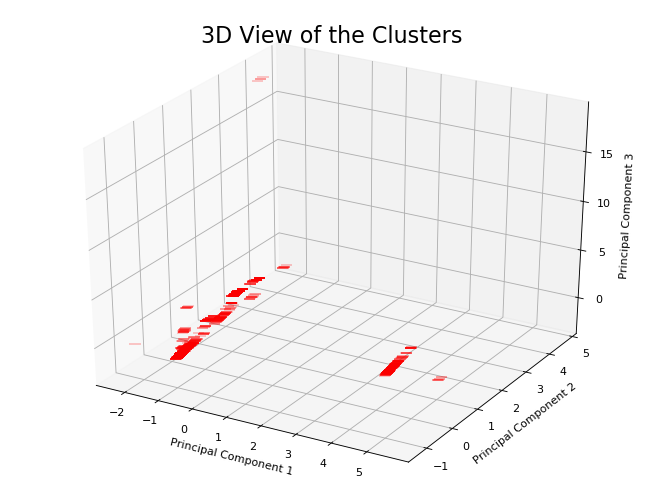

****************************************************************************************************
[[ 0.07290452  0.12617882  0.02649536 -0.46761163  0.06633563 -0.46761159
   0.46761121  0.46759716  0.03841502]
 [-0.33341352 -0.57705231 -0.12117094  2.13852353 -0.30337208  2.13852337
  -2.13852163 -2.13845739 -0.17568302]]
****************************************************************************************************


<Figure size 432x288 with 0 Axes>

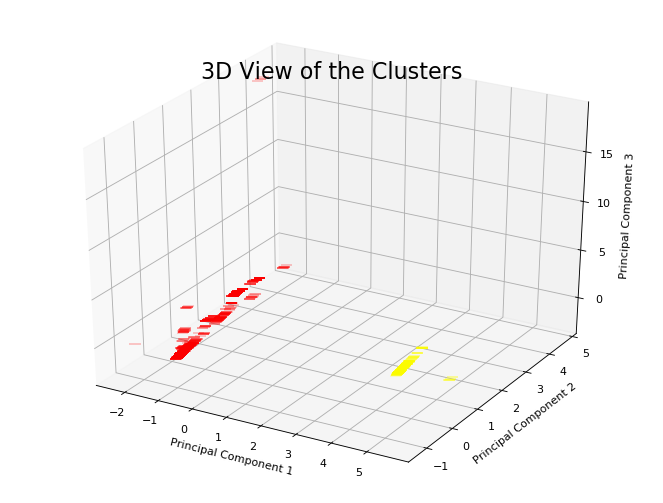

****************************************************************************************************
[[-0.2705083  -0.4882008  -0.02239615 -0.46752647  0.07088489 -0.46749376
   0.46758407  0.46289422 -0.53661458]
 [-0.33341352 -0.57705231 -0.12117094  2.13852353 -0.30337208  2.13852337
  -2.13852163 -2.13845739 -0.17568302]
 [ 0.81541874  1.45456718  0.13220671 -0.46779574  0.0564994  -0.46786636
   0.4676699   0.47776569  1.28172225]]
****************************************************************************************************


<Figure size 432x288 with 0 Axes>

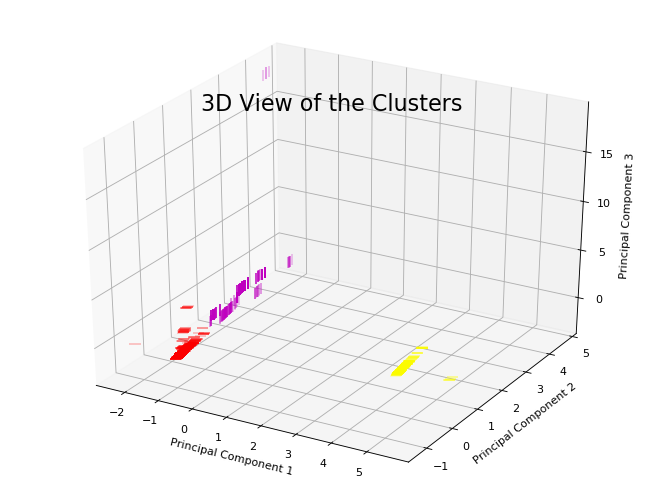

****************************************************************************************************
[[ -0.2705083   -0.4882008   -0.02239615  -0.46752647   0.07088489
   -0.46749376   0.46758407   0.46289422  -0.53661458]
 [ -0.33340616  -0.57669625  -0.12117094   2.13852369   0.0564994
    2.13852356  -2.13842871  -2.13836219  -0.16380798]
 [  0.81541874   1.45456718   0.13220671  -0.46779574   0.0564994
   -0.46786636   0.4676699    0.47776569   1.28172225]
 [ -0.33368829  -0.5903601   -0.12117094   2.13851747 -13.75356868
    2.13851614  -2.14199435  -2.14201557  -0.61951281]]
****************************************************************************************************


<Figure size 432x288 with 0 Axes>

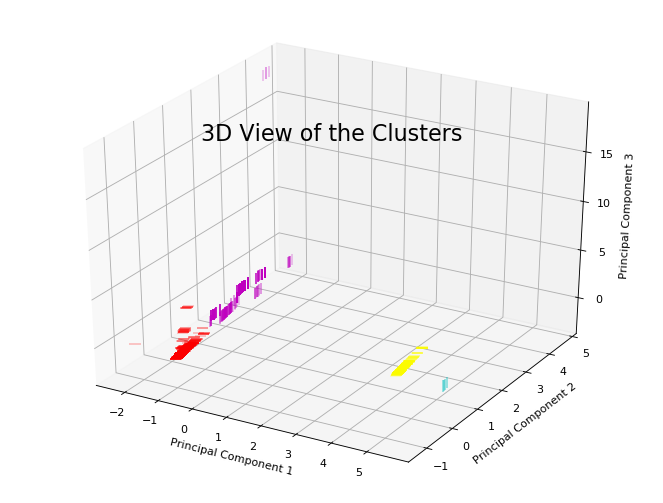

****************************************************************************************************
[[ -0.27190696  -0.49197217  -0.02218994  -0.46752582   0.07091492
   -0.46749366   0.46758429   0.46289461  -0.53648468]
 [ -0.33340616  -0.57669625  -0.12117094   2.13852369   0.0564994
    2.13852356  -2.13842871  -2.13836219  -0.16380798]
 [  0.82390145   1.44894396  -0.04179747  -0.46779582   0.0564994
   -0.46786442   0.4676701    0.47766197   1.26879698]
 [ -0.33368829  -0.5903601   -0.12117094   2.13851747 -13.75356868
    2.13851614  -2.14199435  -2.14201557  -0.61951281]
 [ -0.32990528   2.00779265  19.23298031  -0.46780758   0.0564994
   -0.4679178    0.46755054   0.48169618   1.76968565]]
****************************************************************************************************


<Figure size 432x288 with 0 Axes>

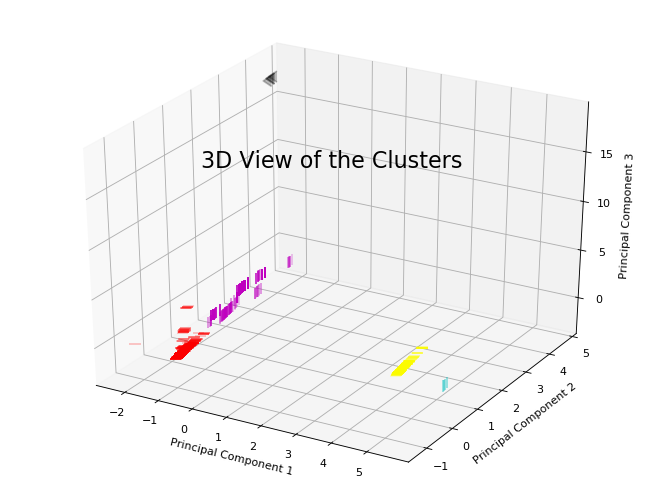

****************************************************************************************************
[[  4.19235146   1.53768346  -0.10285615  -0.4677866    0.0564994
   -0.46784312   0.46763709   0.47426233   0.84660998]
 [ -0.2623733   -0.47326359  -0.02321247  -0.46752892   0.070766
   -0.46749539   0.46758304   0.46289092  -0.53733076]
 [ -0.33340616  -0.57669625  -0.12117094   2.13852369   0.0564994
    2.13852356  -2.13842871  -2.13836219  -0.16380798]
 [  0.15501561   1.43480509  -0.02738092  -0.46779683   0.0564994
   -0.46787433   0.46768246   0.47876205   1.40565611]
 [ -0.33368829  -0.5903601   -0.12117094   2.13851747 -13.75356868
    2.13851614  -2.14199435  -2.14201557  -0.61951281]
 [ -0.32990528   2.00779265  19.23298031  -0.46780758   0.0564994
   -0.4679178    0.46755054   0.48169618   1.76968565]]
****************************************************************************************************


<Figure size 432x288 with 0 Axes>

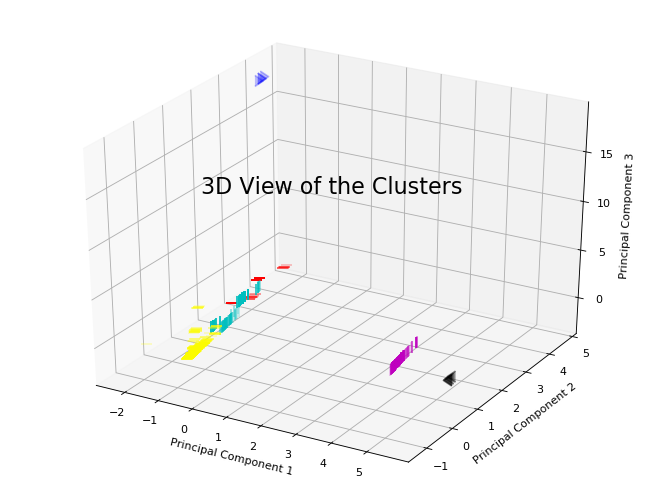

****************************************************************************************************
[[-2.71906962e-01 -4.91972175e-01 -2.21899367e-02 -4.67525825e-01
   7.09149218e-02 -4.67493662e-01  4.67584294e-01  4.62894615e-01
  -5.36484678e-01]
 [-3.33406164e-01 -5.76696245e-01 -1.21170942e-01  2.13852369e+00
   5.64994019e-02  2.13852356e+00 -2.13842871e+00 -2.13836219e+00
  -1.63807978e-01]
 [ 4.39905459e-01  1.31854774e+00 -1.04987855e-02 -4.67770883e-01
   5.64994019e-02 -4.67888211e-01  4.67705080e-01  4.82665831e-01
   1.89499631e+00]
 [ 6.79178455e+00  5.52486213e-01 -1.21170942e-01 -4.67731441e-01
   5.64994019e-02 -4.67723866e-01  4.67794352e-01  4.72366966e-01
   6.17456630e-01]
 [-3.33688287e-01 -5.90360102e-01 -1.21170942e-01  2.13851747e+00
  -1.37535687e+01  2.13851614e+00 -2.14199435e+00 -2.14201557e+00
  -6.19512807e-01]
 [-3.29905282e-01  2.00779265e+00  1.92329803e+01 -4.67807577e-01
   5.64994019e-02 -4.67917799e-01  4.67550539e-01  4.81696175e-01
   1.7696856

<Figure size 432x288 with 0 Axes>

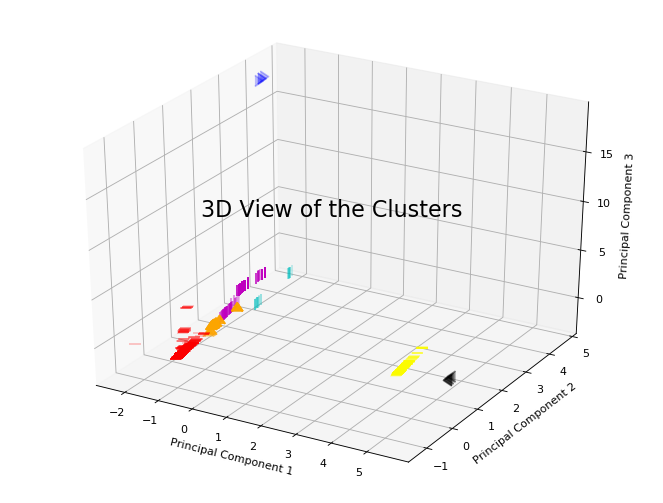

****************************************************************************************************
[[ -0.27139794  -0.4913506   -0.02135641  -0.46761644   0.07103632
   -0.46758752   0.46758572   0.46286678  -0.55122738]
 [ -0.33340616  -0.57669625  -0.12117094   2.13852369   0.0564994
    2.13852356  -2.13842871  -2.13836219  -0.16380798]
 [  0.58060659   1.94636103   0.0333752   -0.46777736   0.0564994
   -0.46794022   0.46756606   0.48190087   1.79893401]
 [ -0.33368829  -0.5903601   -0.12117094   2.13851747 -13.75356868
    2.13851614  -2.14199435  -2.14201557  -0.61951281]
 [  6.79178455   0.55248621  -0.12117094  -0.46773144   0.0564994
   -0.46772387   0.46779435   0.47236697   0.61745663]
 [ -0.32990528   2.00779265  19.23298031  -0.46780758   0.0564994
   -0.4679178    0.46755054   0.48169618   1.76968565]
 [  0.54919796   2.08641441  -0.12117094  -0.46789096   0.0564994
   -0.46782416   0.46752815   0.4631235   -0.5534198 ]
 [  0.05095418  -0.2894958   -0.12115973  -0.46685

<Figure size 432x288 with 0 Axes>

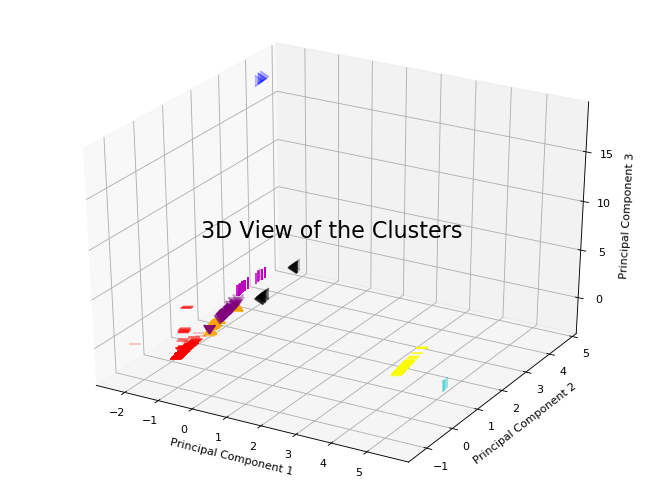

****************************************************************************************************
[[ -0.27139794  -0.4913506   -0.02135641  -0.46761644   0.07103632
   -0.46758752   0.46758572   0.46286678  -0.55122738]
 [ -0.33340616  -0.57669625  -0.12117094   2.13852369   0.0564994
    2.13852356  -2.13842871  -2.13836219  -0.16380798]
 [  0.21481086   1.93592197   0.05197424  -0.46777736   0.0564994
   -0.4679408    0.46756675   0.48205956   1.81869485]
 [ -0.33368829  -0.5903601   -0.12117094   2.13851747 -13.75356868
    2.13851614  -2.14199435  -2.14201557  -0.61951281]
 [  6.79178455   0.55248621  -0.12117094  -0.46773144   0.0564994
   -0.46772387   0.46779435   0.47236697   0.61745663]
 [ -0.32990528   2.00779265  19.23298031  -0.46780758   0.0564994
   -0.4679178    0.46755054   0.48169618   1.76968565]
 [  0.15029037   2.07128889  -0.12117094  -0.46788968   0.0564994
   -0.46782096   0.46752687   0.46311199  -0.55469362]
 [  0.05095418  -0.2894958   -0.12115973  -0.46685

<Figure size 432x288 with 0 Axes>

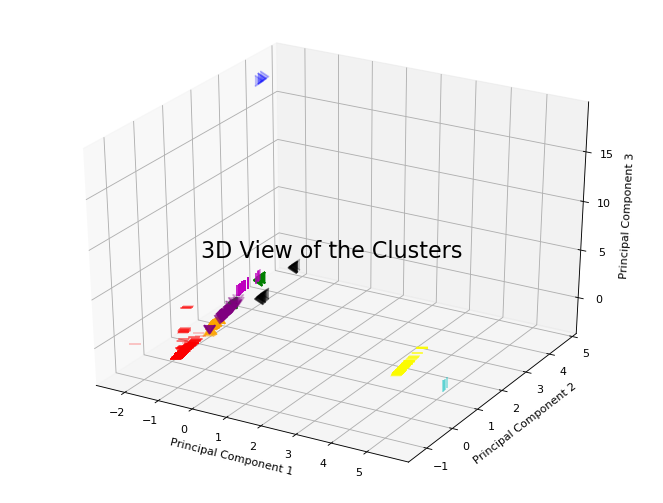

****************************************************************************************************
[[ -0.27133195  -0.49125657  -0.02125123  -0.46761908   0.0564994
   -0.46759056   0.4675859    0.46286529  -0.55173976]
 [ -0.33340616  -0.57669625  -0.12117094   2.13852369   0.0564994
    2.13852356  -2.13842871  -2.13836219  -0.16380798]
 [  2.80967429   2.06172455  -0.09311425  -0.46781593   0.0564994
   -0.46790655   0.46755344   0.4752705    0.96850006]
 [ -0.32990528   2.00779265  19.23298031  -0.46780758   0.0564994
   -0.4679178    0.46755054   0.48169618   1.76968565]
 [ -0.33368829  -0.5903601   -0.12117094   2.13851747 -13.75356868
    2.13851614  -2.14199435  -2.14201557  -0.61951281]
 [  0.21481086   1.93592197   0.05197424  -0.46777736   0.0564994
   -0.4679408    0.46756675   0.48205956   1.81869485]
 [  6.79178455   0.55248621  -0.12117094  -0.46773144   0.0564994
   -0.46772387   0.46779435   0.47236697   0.61745663]
 [  0.15029037   2.07128889  -0.12117094  -0.467889

<Figure size 432x288 with 0 Axes>

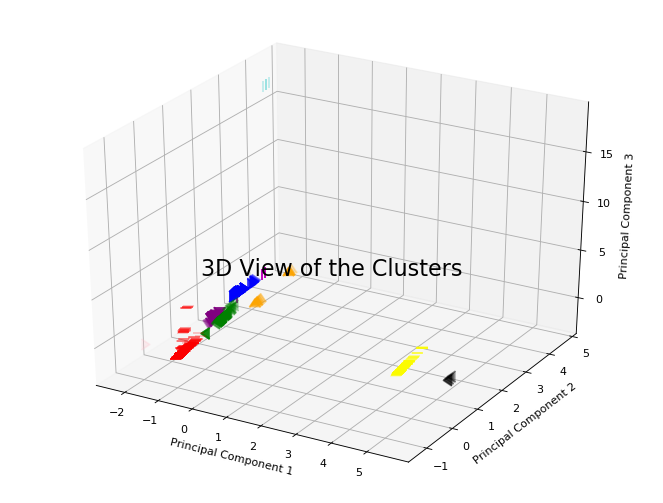

PermissionError: [Errno 13] Permission denied: 'Cluster_results.csv'

<Figure size 432x288 with 0 Axes>

In [12]:
if __name__ == "__main__":
    sm = SpendAnomaliesModel('./Packaging_data.csv')  

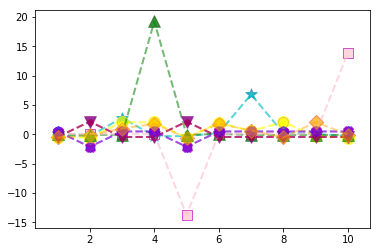

In [62]:
diff_quant = [-0.27133195,-0.33340616,2.80967429,-0.32990528,-0.33368829,0.21481086,6.79178455,0.15029037,0.05095418,-0.33402153]
diff_amount = [-0.49125657,-0.57669625,2.06172455,2.00779265,-0.5903601,1.93592197,0.55248621,2.07128889,-0.2894958,-0.58059328]
unit_price_var = [-0.02125123,-0.12117094,-0.09311425,19.23298031,-0.12117094,0.05197424,-0.12117094,-0.12117094,-0.12115973,-0.12117094]
pay_after_days = [-0.46761908,2.13852369,-0.46781593,-0.46780758,2.13851747,-0.46777736,-0.46773144,-0.46788968,-0.46685742,-0.46511867]
pd_pc = [0.0564994,0.0564994,0.0564994,0.0564994,-13.75356868,0.0564994,0.0564994,0.0564994,0.0564994,13.86656748]
vc_vr = [-0.46759056,2.13852356,-0.46790655,-0.4679178,2.13851614,-0.4679408,-0.46772387,-0.46782096,-0.4668257,-0.46470069] 
vr_vi = [0.4675859,-2.13842871,0.46755344,0.46755054,-2.14199435,0.46756675,0.46779435,0.46752687,0.46800336,0.46741441]
vr_pc = [0.46286529,-2.13836219,0.4752705,0.48169618,-2.14201557,0.48205956,0.47236697,0.46311199,0.48309362,0.46427561]
ac_pc = [-0.55173976,-0.16380798,0.96850006,1.76968565,-0.61951281,1.81869485,0.61745663,-0.55469362,2.06193366,-0.06497815]


cluster_names = list(np.arange(10)+1)


plt.scatter(cluster_names,diff_quant,marker='*', c = 'c', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.65 )
plt.plot(cluster_names,diff_quant, color='c', marker='*', linestyle='dashed', linewidth=2, markersize=12, alpha=0.65)
plt.scatter(cluster_names,diff_amount,marker='o', c = 'yellow', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.65 )
plt.plot(cluster_names,diff_amount, color='yellow', marker='o', linestyle='dashed', linewidth=2, markersize=12, alpha=0.65)
plt.scatter(cluster_names,unit_price_var,marker='^', c = 'g', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.55 )
plt.plot(cluster_names,unit_price_var, color='g', marker='^', linestyle='dashed', linewidth=2, markersize=12, alpha=0.55)
plt.scatter(cluster_names,pay_after_days,marker='.', c = 'r', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.55 )
plt.plot(cluster_names,pay_after_days, color='r', marker='.', linestyle='dashed', linewidth=2, markersize=12, alpha=0.55)
plt.scatter(cluster_names,pd_pc,marker=',', c = 'pink', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.65 )
plt.plot(cluster_names,pd_pc, color='pink', marker=',', linestyle='dashed', linewidth=2, markersize=12, alpha=0.65)
plt.scatter(cluster_names,vc_vr,marker='v', c = 'purple', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.55 )
plt.plot(cluster_names,vc_vr, color='purple', marker='v', linestyle='dashed', linewidth=2, markersize=12, alpha=0.55)
plt.scatter(cluster_names,vr_vi,marker='h', c = 'b', s = 100, edgecolors = 'm', linewidths = 1, alpha=0.45 )
plt.plot(cluster_names,vr_vi, color='b', marker='h', linestyle='dashed', linewidth=2, markersize=10, alpha=0.45)
plt.scatter(cluster_names,vr_pc,marker='X', c = 'm', s = 100, edgecolors = 'm', linewidths = 1,alpha=0.45 )
plt.plot(cluster_names,vr_pc, color='m', marker='X', linestyle='dashed', linewidth=2, markersize=10,alpha=0.45)
plt.scatter(cluster_names,ac_pc,marker='D', c = 'orange', s = 100, edgecolors = 'm', linewidths = 1,alpha=0.45 )
plt.plot(cluster_names,ac_pc, color='orange', marker='D', linestyle='dashed', linewidth=2, markersize=10,alpha=0.45)
plt.show()

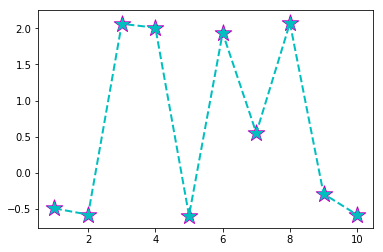

In [43]:

plt.show()

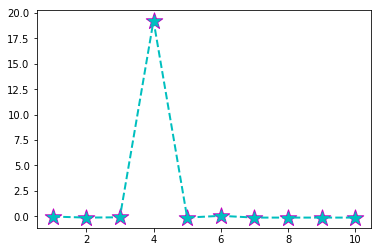

In [44]:

plt.show()

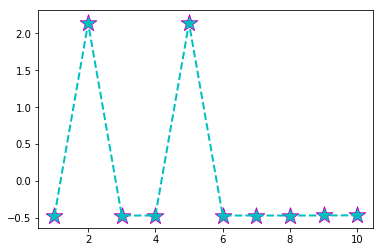

In [45]:

plt.show()

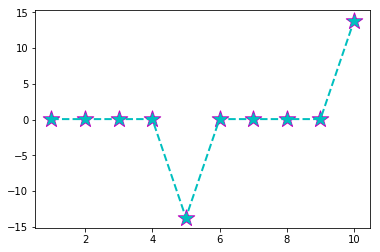

In [46]:

plt.show()

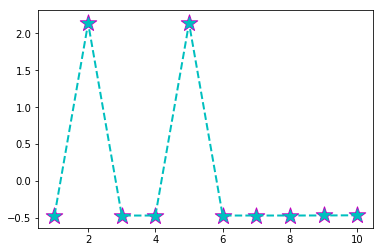

In [47]:

plt.show()

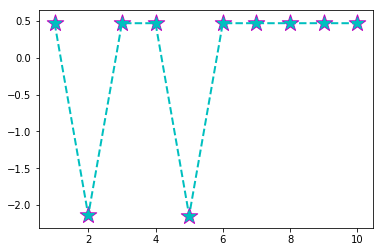

In [48]:

plt.show()

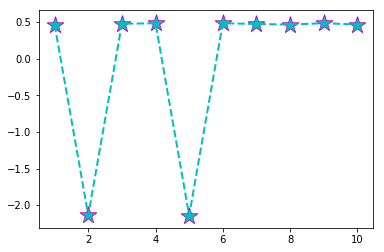

In [49]:

plt.show()

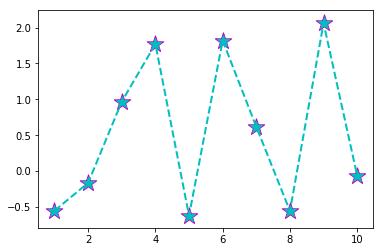

In [50]:

plt.show()